In [ ]:
import tensorflow.keras
import h5py
import PIL.Image
import os, shutil
from tensorflow.keras.models import load_model
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU
from keras.regularizers import l2

INFO:tensorflow:Using local port 22423
INFO:tensorflow:Using local port 24856
INFO:tensorflow:Using local port 15543
INFO:tensorflow:Using local port 15246
INFO:tensorflow:Using local port 21051
INFO:tensorflow:Using local port 18359
INFO:tensorflow:Using local port 24839
INFO:tensorflow:Using local port 23383
INFO:tensorflow:Using local port 24181
INFO:tensorflow:Using local port 22729


ModuleNotFoundError: No module named 'keras'

In [ ]:
!unzip /content/Post-hurricane.zip -d /content/hurricane-damage

# EDA

In [ ]:
input_path = '/content/hurricane-damage/'

def print_file_sizes(input_path, subset):
    print('{}:'.format(subset))
    print('')
    path = input_path + subset + '/'
    for f in os.listdir(path):
        if not os.path.isdir(path + f):
            print(f.ljust(30) + str(round(os.path.getsize(path + f) / 1000000, 2)) + 'MB')
        else:
            sizes = [os.path.getsize(path+f+'/'+x)/1000000 for x in os.listdir(path + f)]
            print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))
    print('')
    
print_file_sizes(input_path, 'train_another')
print_file_sizes(input_path, 'validation_another')
print_file_sizes(input_path, 'test_another')
print_file_sizes(input_path, 'test')

train_another:

no_damage                     15.07MB (5000 files)
damage                        12.56MB (5000 files)
.DS_Store                     0.01MB

validation_another:

no_damage                     3.02MB (1000 files)
damage                        2.52MB (1000 files)

test_another:

no_damage                     3.01MB (1000 files)
damage                        20.12MB (8000 files)

test:

no_damage                     2.99MB (1000 files)
damage                        2.53MB (1000 files)
.DS_Store                     0.01MB



In [ ]:
#Making a dataframe
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

image_df = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})

image_df['damage'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string

image_df.head()

path  ...        lat
0  /content/hurricane-damage/test_another/no_dama...  ...  30.040518
1  /content/hurricane-damage/test_another/no_dama...  ...  29.961827
2  /content/hurricane-damage/test_another/no_dama...  ...  29.833849
3  /content/hurricane-damage/test_another/no_dama...  ...  29.854290
4  /content/hurricane-damage/test_another/no_dama...  ...  29.827029

[5 rows x 6 columns]

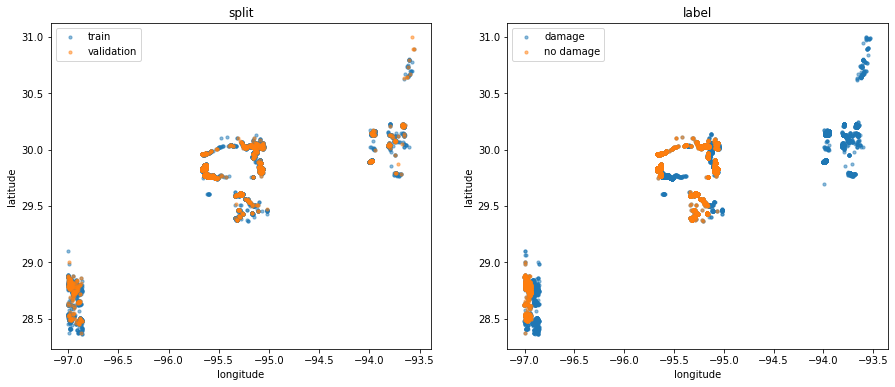

In [ ]:
#Generating quick plot of the spatial distribution of the images:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

s = 10
alpha = 0.5

# get the train-validation-test splits
image_df_train = image_df[image_df['data_split']=='train_another'].copy()
image_df_val = image_df[image_df['data_split']=='validation_another'].copy()
image_df_test = image_df[image_df['data_split']=='test_another'].copy()

# sort to ensure reproducible behaviour
image_df_train.sort_values('lat', inplace=True)
image_df_val.sort_values('lat', inplace=True)
image_df_test.sort_values('lat', inplace=True)
image_df_train.reset_index(drop=True,inplace=True)
image_df_val.reset_index(drop=True,inplace=True)
image_df_test.reset_index(drop=True,inplace=True)

ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C0', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='C1', s=s, alpha=alpha, label='validation')

ax[0].set_title('split')
ax[0].legend()
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

image_df_dmg = image_df[image_df['damage']=='damage'].copy()
image_df_nodmg = image_df[image_df['damage']=='no_damage'].copy()

image_df_dmg.reset_index(drop=True,inplace=True)
image_df_nodmg.reset_index(drop=True,inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')

ax[1].set_title('label')
ax[1].legend()
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')

plt.show(fig)

In [ ]:
import cv2

img = cv2.imread(image_df['path'][0], cv2.IMREAD_UNCHANGED)
np.shape(img)

(128, 128, 3)

In [ ]:
print("Type:==> ", type(img[0,0,0]))
print("Min value==>", np.min(img[:,:,:]))
print("Max value==>", np.max(img[:,:,:]))

Type:==>  <class 'numpy.uint8'>
Min value==> 0
Max value==> 255


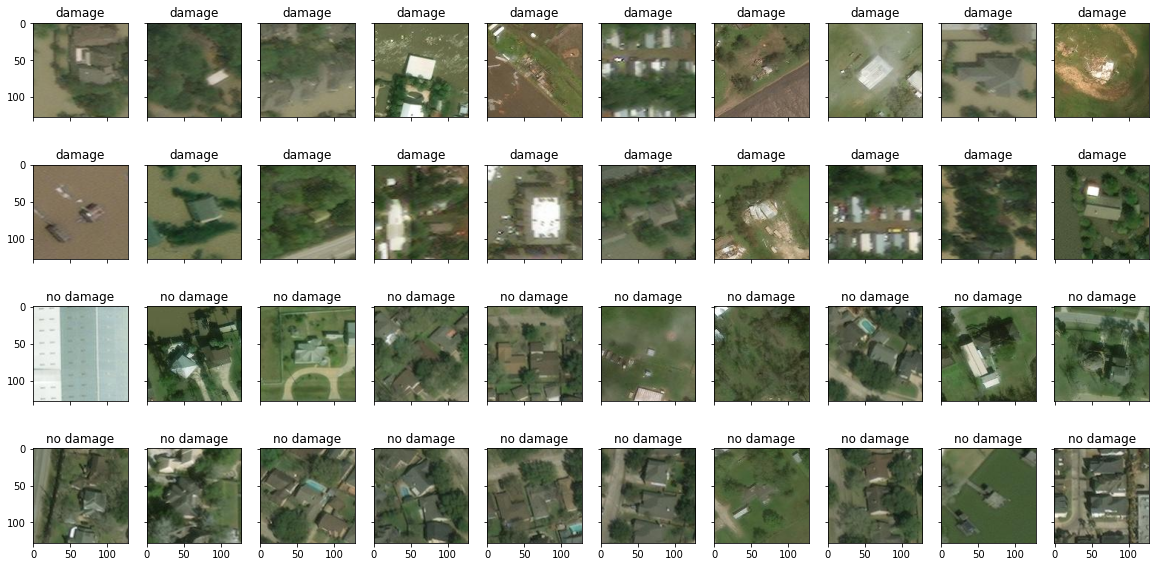

In [ ]:
#Checking out images
fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20,10))

ax = ax.flatten()

for i in range(20):
    img = cv2.imread(image_df_dmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('damage')
    
for i in range(20,40):
    img = cv2.imread(image_df_nodmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('no damage')
    
plt.show()

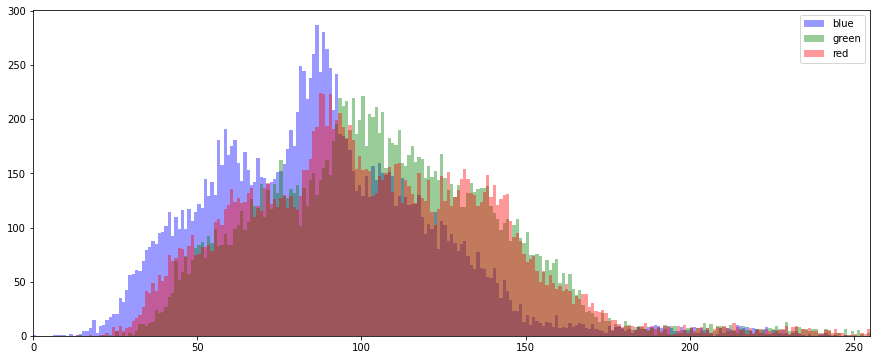

In [ ]:
#Histogram view of RGB values
jpg_channels = ['blue','green','red']
jpg_channel_colors = ['b','g','r']

fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(jpg_channels)):
    ax.hist(img[:,:,i].flatten(), bins=np.arange(256),
            label=jpg_channels[i], color=jpg_channel_colors[i], alpha=0.4)
    ax.legend()
    
ax.set_xlim(0,255)
    
plt.show(fig)

# Building Models

In [ ]:
dataset_dir = '/content/hurricane_damage'
train_damage_dir = '/content/hurricane-damage/train_another/damage'
validation_damage_dir = '/content/hurricane-damage/validation_another/damage'
test_damage_dir = '/content/hurricane-damage/test_another/damage'

train_nodamage_dir = '/content/hurricane-damage/train_another/no_damage'
validation_nodamage_dir = '/content/hurricane-damage/validation_another/no_damage'
test_nodamage_dir = '/content/hurricane-damage/test_another/no_damage'

In [ ]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))
print("======================================")
print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  8000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [ ]:
from keras import layers
from keras import models
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), input_shape=(150, 150, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
#compile the model with RMSprob with learning rate
from keras import optimizers
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics = ['accuracy'])

In [ ]:
#Processing the image via an image generator
from keras.preprocessing.image import ImageDataGenerator

#We will normalize the image value
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_datagenerator = train_datagen.flow_from_directory('/content/hurricane-damage/train_another', target_size=(150, 150), batch_size=20, class_mode='binary')
validation_datagenerator = validation_datagen.flow_from_directory('/content/hurricane-damage/validation_another', target_size=(150, 150), batch_size=20, class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
#fitting the model from image generator
from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_accuracy', patience=15)

#Callback for saving best model
es = EarlyStopping(
    monitor='val_accuracy', patience=10, mode='auto',
    baseline=None, restore_best_weights=True)

history = model.fit(train_datagenerator, steps_per_epoch=100, epochs=70, validation_data=validation_datagenerator, validation_steps=50, callbacks=[es])

In [ ]:
!pwd

/content


In [ ]:
#Saving model with best weight
!mkdir -p /content/models/
model.save('/content/models/vanillaCNNmodel.h5')
!ls -ltrh /content/models/

total 27M
-rw-r--r-- 1 root root 27M Dec 10 22:02 vanilaCNNmodel.h5


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    '/content/hurricane-damage/test', #balanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [ ]:
test_results = model.evaluate(test_generator)
test_results

100/100 [==============================] - 2s 16ms/step - loss: 0.0854 - accuracy: 0.9685


[0.08537352085113525, 0.968500018119812]

In [ ]:
test_another_datagen = ImageDataGenerator(rescale=1./255)
test_another_generator = test_another_datagen.flow_from_directory(
                    '/content/hurricane-damage/test_another', #Unbalanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

Found 9000 images belonging to 2 classes.


In [ ]:
test_another_results = model.evaluate(test_another_generator)
test_another_results

450/450 [==============================] - 7s 16ms/step - loss: 0.0832 - accuracy: 0.9679


[0.08315686881542206, 0.9678888916969299]

In [ ]:
print("Test accuracy \n Balanced Test set   = {} \n Unbalanced Test set = {}".format(np.around(test_results[1], 3), np.around(test_another_results[1], 3)))

Test accuracy 
 Balanced Test set   = 0.969 
 Unbalanced Test set = 0.968


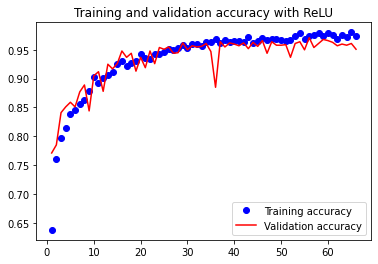

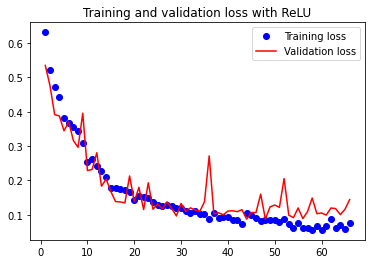

In [ ]:
#plot of loss and accuracy 
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy with ReLU')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss with ReLU')
plt.legend()

plt.show()

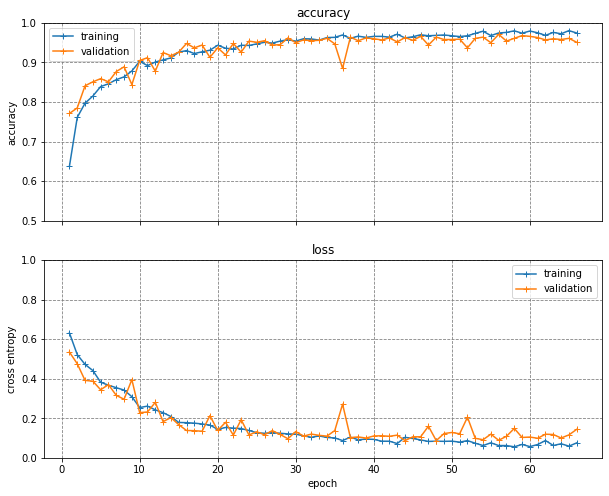

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, 66+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()


#Tuning Vanilla model with Dropout and without callbacks

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
                optimizer = optimizers.Adam(),
                 metrics = ['accuracy'])

#train using data augmentation and dropout
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,vertical_flip = True,
                    horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255) #validation data should not be augmented
train_generator = train_datagen.flow_from_directory(
                    '/content/hurricane-damage/train_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
                    '/content/hurricane-damage/validation_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')
#train the model with fit_generator

#fitting the model from image generator
from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_accuracy', patience=15)

#Callback for early stopping
es = EarlyStopping(
    monitor='val_accuracy', patience=15, mode='auto',
    baseline=None, restore_best_weights=True)

history = model.fit_generator(
            train_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_data = validation_generator,
            validation_steps = 50, callbacks=[es])

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 18s 178ms/step - loss: 0.6276 - accuracy: 0.6347 - val_loss: 0.4833 - val_accuracy: 0.8100
Epoch 2/100
100/100 [==============================] - 18s 178ms/step - loss: 0.4473 - accuracy: 0.8097 - val_loss: 0.3936 - val_accuracy: 0.8194
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 0.3582 - accuracy: 0.8531 - val_loss: 0.2632 - val_accuracy: 0.8881
Epoch 4/100
100/100 [==============================] - 18s 180ms/step - loss: 0.3019 - accuracy: 0.8819 - val_loss: 0.2272 - val_accuracy: 0.9106
Epoch 5/100
100/100 [==============================] - 18s 177ms/step - loss: 0.3125 - accuracy: 0.8759 - val_loss: 0.2310 - val_accuracy: 0.9162
Epoch 6/100
100/100 [==============================] - 18s 179ms/step - loss: 0.2650 - accuracy: 0.8951 - val_loss: 0.2049 - val_accuracy: 0.9112
Epoch 7/100
100/100 [==================

In [ ]:
!mkdir -p /content/models/
model.save('/content/models/vanillaCNNmodelDRPOUT.h5')
!ls -ltrh /content/models/

total 66M
-rw-r--r-- 1 root root 27M Dec 10 22:02 vanilaCNNmodel.h5
-rw-r--r-- 1 root root 40M Dec 10 23:09 vanillaCNNmodelDRPOUT.h5


In [ ]:
#Evaluating with balanced and unbalanced test datsets
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    '/content/hurricane-damage/test', #balanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

test_another_datagen = ImageDataGenerator(rescale=1./255)
test_another_generator = test_another_datagen.flow_from_directory(
                    '/content/hurricane-damage/test_another', #Unbalanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

test_results = model.evaluate(test_generator)
test_results
test_another_results = model.evaluate(test_another_generator)
test_another_results

Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
450/450 [==============================] - 7s 16ms/step - loss: 0.0750 - accuracy: 0.9751


[0.07499739527702332, 0.9751111268997192]

In [ ]:
print("Test accuracy \n Balanced Test set   = {} \n Unbalanced Test set = {}".format(np.around(test_results[1], 3), np.around(test_another_results[1], 3)))

Test accuracy 
 Balanced Test set   = 0.94 
 Unbalanced Test set = 0.975


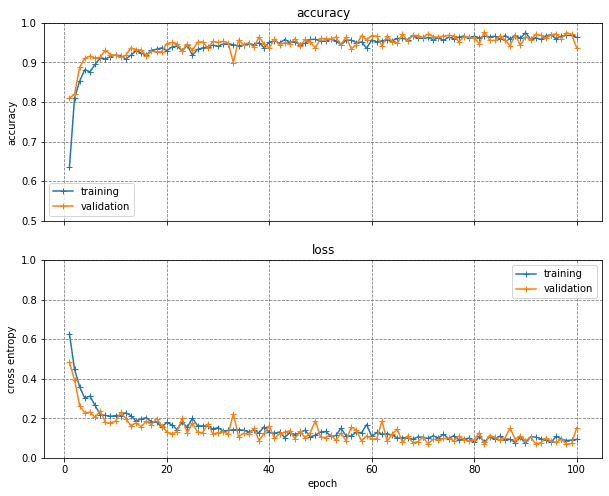

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, 100+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()


Checking Image layer by layer

In [ ]:
img_path = '/content/hurricane-damage/train_another/damage/-93.606053_30.799283000000003.jpeg'
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


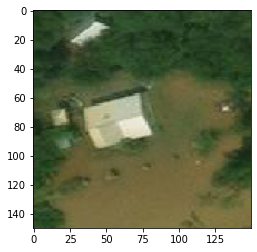

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

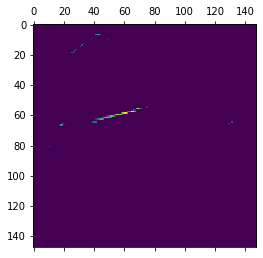

In [ ]:
#First Layer
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0,:,:,4],cmap = 'viridis')

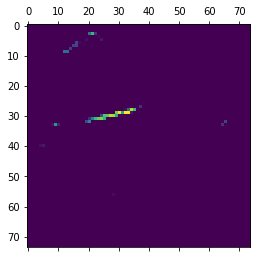

In [ ]:
second_layer_activation = activations[1]
plt.matshow(second_layer_activation[0,:,:,4],cmap = 'viridis')

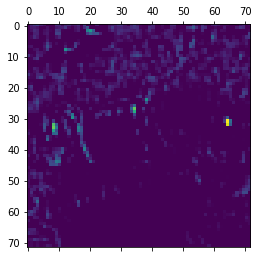

In [ ]:
third_layer_activation = activations[2]
plt.matshow(third_layer_activation[0,:,:,4],cmap = 'viridis')

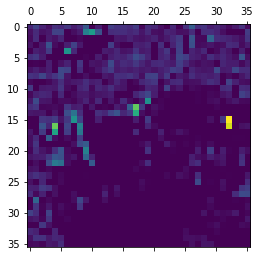

In [ ]:
fourth_layer_activation = activations[3]
plt.matshow(fourth_layer_activation[0,:,:,4],cmap = 'viridis')

In [ ]:
# layer_names =[]
# for layer in model.layers[:8]:
#     layer_names.append(layer.name)
# images_per_row = 16

# for layer_name, layer_activation in zip(layer_names, activations):
#     n_features = layer_activation.shape[-1]
#     size = layer_activation.shape[1]
#     n_cols = n_features//images_per_row
#     display_grid = np.zeros((size*n_cols, images_per_row*size))
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,:,:,col*images_per_row+row]
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col*size:(col+1)*size,row*size:(row+1)*size] = channel_image
#     scale = 1./size
#     plt.figure(figsize=(scale*display_grid.shape[1],
#                         scale*display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

In [ ]:
#Using VGG16
from keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                    include_top = False, #no dense layers
                    input_shape = (150,150,3))
regularaizer = tf.keras.regularizers.l2(0.1)


conv_base.summary()



58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu', kernel_regularizer=regularizer))
model.add(layers.Dense(1,activation = 'sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv_base.trainable = False #freeze the convolutional base network
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

#train using transfer learning and data augmentation
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,vertical_flip = True,
                    horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255) #validation data should not be augmented
train_generator = train_datagen.flow_from_directory(
                    '/content/hurricane-damage/train_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
                    '/content/hurricane-damage/validation_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 2e-5),
              metrics = ['accuracy'])

from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_accuracy', patience=15)

#Callback for saving best model
es = EarlyStopping(
    monitor='val_accuracy', patience=15, mode='auto',
    baseline=None, restore_best_weights=True)

history = model.fit(
            train_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_data = validation_generator,
            validation_steps = 50, callbacks=[es])


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 21s 208ms/step - loss: 0.4526 - accuracy: 0.8278 - val_loss: 0.3621 - val_accuracy: 0.8562
Epoch 2/100
100/100 [==============================] - 21s 206ms/step - loss: 0.3773 - accuracy: 0.8388 - val_loss: 0.3168 - val_accuracy: 0.8737
Epoch 3/100
100/100 [==============================] - 21s 211ms/step - loss: 0.3431 - accuracy: 0.8594 - val_loss: 0.2992 - val_accuracy: 0.8788
Epoch 4/100
100/100 [==============================] - 21s 207ms/step - loss: 0.3234 - accuracy: 0.8687 - val_loss: 0.2793 - val_accuracy: 0.8894
Epoch 5/100
100/100 [==============================] - 21s 208ms/step - loss: 0.3225 - accuracy: 0.8637 - val_loss: 0.2743 - val_accuracy: 0.8931
Epoch 6/100
100/100 [==============================] - 21s 211ms/step - loss: 0.3190 - accuracy: 0.8684 - val_loss: 0.2706 - val_accuracy: 0.8913
Epoch 7/100
100/100 [==================

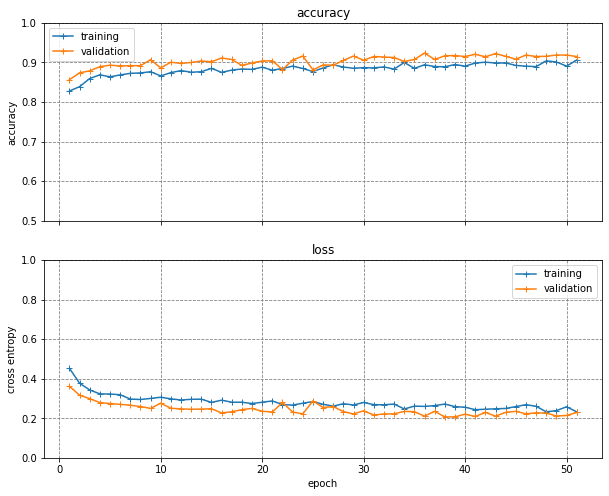

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, 51+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()


In [ ]:
# unfreeze the layers
conv_base.trainable = True
# let's take a look to see how many layers are in the base model
print("Number of layers in the pre-trained model: ", len(conv_base.layers))

Number of layers in the pre-trained model:  19


In [ ]:
# fine-tune from this layer onwards
fine_tune_at = 15

# freeze all the layers before the `fine_tune_at` layer
for layer in conv_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=optimizers.Adam(lr=base_learning_rate/10),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
#train using transfer learning and data augmentation
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,vertical_flip = True,
                    horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255) #validation data should not be augmented
train_generator = train_datagen.flow_from_directory(
                    '/content/hurricane-damage/train_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
                    '/content/hurricane-damage/validation_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 2e-5),
              metrics = ['accuracy'])

from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_accuracy', patience=15)

#Callback for saving best model
es = EarlyStopping(
    monitor='val_accuracy', patience=15, mode='auto',
    baseline=None, restore_best_weights=True)

history = model.fit(
            train_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_data = validation_generator,
            validation_steps = 50, callbacks=[es])


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 22s 217ms/step - loss: 0.3131 - accuracy: 0.8728 - val_loss: 0.2042 - val_accuracy: 0.9169
Epoch 2/100
100/100 [==============================] - 22s 216ms/step - loss: 0.2486 - accuracy: 0.9009 - val_loss: 0.1895 - val_accuracy: 0.9219
Epoch 3/100
100/100 [==============================] - 21s 213ms/step - loss: 0.2374 - accuracy: 0.9000 - val_loss: 0.2077 - val_accuracy: 0.9206
Epoch 4/100
100/100 [==============================] - 22s 218ms/step - loss: 0.2247 - accuracy: 0.9034 - val_loss: 0.3105 - val_accuracy: 0.8950
Epoch 5/100
100/100 [==============================] - 22s 216ms/step - loss: 0.1999 - accuracy: 0.9197 - val_loss: 0.1767 - val_accuracy: 0.9312
Epoch 6/100
100/100 [==============================] - 22s 216ms/step - loss: 0.1983 - accuracy: 0.9209 - val_loss: 0.1493 - val_accuracy: 0.9500
Epoch 7/100
100/100 [==================

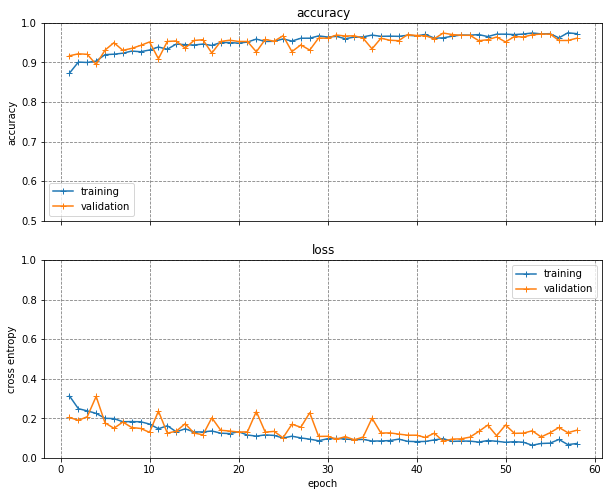

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, 58+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()


In [ ]:
!mkdir -p /content/models/
model.save('/content/models/vanillaCNNmodel_VGGtrainableWeights.h5')
!ls -ltrh /content/models/

total 166M
-rw-r--r-- 1 root root  27M Dec 10 22:02 vanilaCNNmodel.h5
-rw-r--r-- 1 root root  40M Dec 10 23:09 vanillaCNNmodelDRPOUT.h5
-rw-r--r-- 1 root root 100M Dec 11 00:25 vanillaCNNmodel_VGGtrainableWeights.h5


In [ ]:
#Evaluating with balanced and unbalanced test datsets
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    '/content/hurricane-damage/test', #balanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

test_another_datagen = ImageDataGenerator(rescale=1./255)
test_another_generator = test_another_datagen.flow_from_directory(
                    '/content/hurricane-damage/test_another', #Unbalanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

test_results = model.evaluate(test_generator)
test_results
test_another_results = model.evaluate(test_another_generator)
test_another_results

Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
450/450 [==============================] - 25s 56ms/step - loss: 0.0912 - accuracy: 0.9728


[0.09117259830236435, 0.972777783870697]

In [ ]:
print("Test accuracy \n Balanced Test set   = {} \n Unbalanced Test set = {}".format(np.around(test_results[1], 3), np.around(test_another_results[1], 3)))

Test accuracy 
 Balanced Test set   = 0.972 
 Unbalanced Test set = 0.973


# Inception

In [ ]:
#Using InceptionV3
from keras.applications import InceptionV3
conv_base_Inception = InceptionV3(weights = 'imagenet',
                    include_top = False, #no dense layers
                    input_shape = (150,150,3))
conv_base_Inception.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base_Inception)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation = 'sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 26,521,889
Trainable params: 26,487,457
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# unfreeze the layers
conv_base_Inception.trainable = True
# let's take a look to see how many layers are in the base model
print("Number of layers in the pre-trained model: ", len(conv_base_Inception.layers))

Number of layers in the pre-trained model:  311


In [ ]:
# fine-tune from this layer onwards
fine_tune_at = 249

# freeze all the layers before the `fine_tune_at` layer
for layer in conv_base_Inception.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=optimizers.Adam(lr=base_learning_rate/10),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 26,521,889
Trainable params: 15,833,985
Non-trainable params: 10,687,904
_________________________________________________________________


In [ ]:
#train using transfer learning and data augmentation
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,vertical_flip = True,
                    horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255) #validation data should not be augmented
train_generator = train_datagen.flow_from_directory(
                    '/content/hurricane-damage/train_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
                    '/content/hurricane-damage/validation_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 2e-5),
              metrics = ['accuracy'])

from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_accuracy', patience=15)

#Callback for saving best model
es = EarlyStopping(
    monitor='val_accuracy', patience=15, mode='auto',
    baseline=None, restore_best_weights=True)

history = model.fit(
            train_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_data = validation_generator,
            validation_steps = 50, callbacks=[es])


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 20s 202ms/step - loss: 0.4556 - accuracy: 0.8016 - val_loss: 0.3837 - val_accuracy: 0.8462
Epoch 2/100
100/100 [==============================] - 20s 196ms/step - loss: 0.3260 - accuracy: 0.8597 - val_loss: 0.3413 - val_accuracy: 0.8681
Epoch 3/100
100/100 [==============================] - 20s 199ms/step - loss: 0.2811 - accuracy: 0.8825 - val_loss: 0.2937 - val_accuracy: 0.8819
Epoch 4/100
100/100 [==============================] - 19s 193ms/step - loss: 0.2434 - accuracy: 0.8975 - val_loss: 0.2561 - val_accuracy: 0.8994
Epoch 5/100
100/100 [==============================] - 20s 199ms/step - loss: 0.2509 - accuracy: 0.9001 - val_loss: 0.2150 - val_accuracy: 0.9131
Epoch 6/100
100/100 [==============================] - 19s 194ms/step - loss: 0.2157 - accuracy: 0.9100 - val_loss: 0.2214 - val_accuracy: 0.9125
Epoch 7/100
100/100 [==================

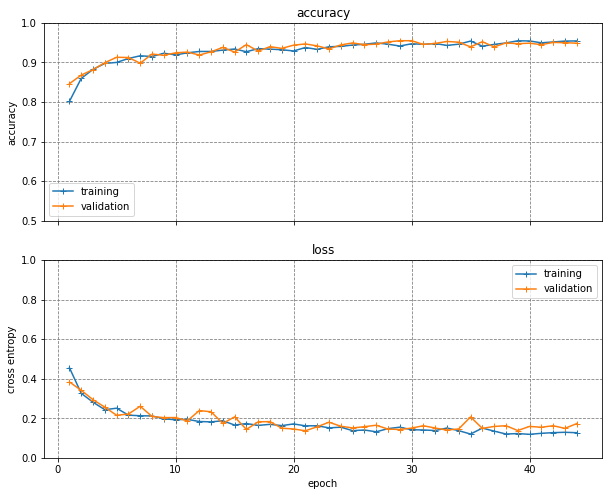

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, 44+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()


In [ ]:
!mkdir -p /content/models/
model.save('/content/models/vanillaCNNmodel_INCEPTION_trainableWeights.h5')
!ls -ltrh /content/models/

total 328M
-rw-r--r-- 1 root root  27M Dec 10 22:02 vanilaCNNmodel.h5
-rw-r--r-- 1 root root  40M Dec 10 23:09 vanillaCNNmodelDRPOUT.h5
-rw-r--r-- 1 root root 100M Dec 11 00:25 vanillaCNNmodel_VGGtrainableWeights.h5
-rw-r--r-- 1 root root 163M Dec 11 00:46 vanillaCNNmodel_INCEPTION_trainableWeights.h5


In [ ]:
#Evaluating with balanced and unbalanced test datsets
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    '/content/hurricane-damage/test', #balanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

test_another_datagen = ImageDataGenerator(rescale=1./255)
test_another_generator = test_another_datagen.flow_from_directory(
                    '/content/hurricane-damage/test_another', #Unbalanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

test_results = model.evaluate(test_generator)
test_results
test_another_results = model.evaluate(test_another_generator)
test_another_results

Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
450/450 [==============================] - 11s 24ms/step - loss: 0.1738 - accuracy: 0.9412


[0.17382818460464478, 0.9412222504615784]

In [ ]:
print("Test accuracy \n Balanced Test set   = {} \n Unbalanced Test set = {}".format(np.around(test_results[1], 3), np.around(test_another_results[1], 3)))

Test accuracy 
 Balanced Test set   = 0.942 
 Unbalanced Test set = 0.941


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


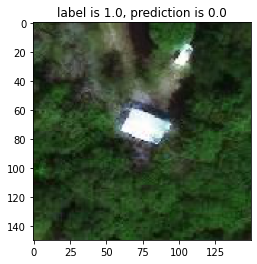

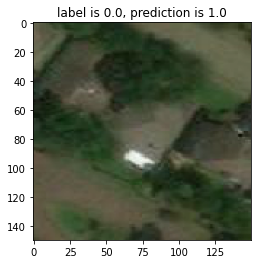

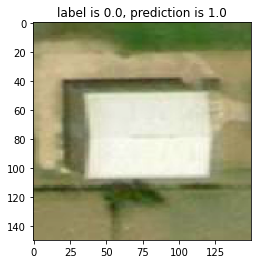

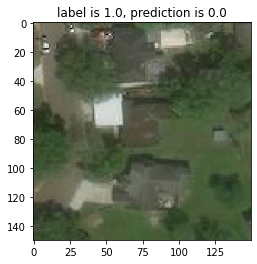

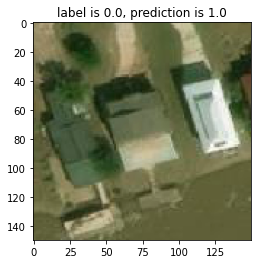

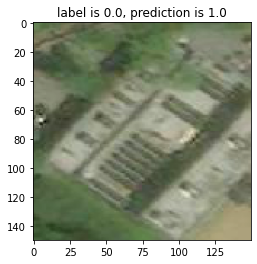

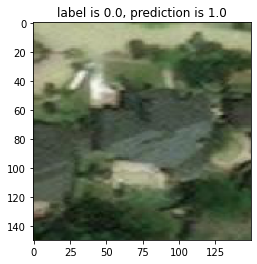

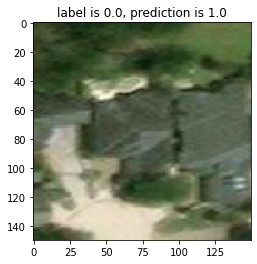

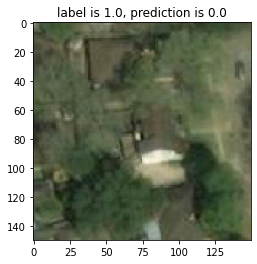

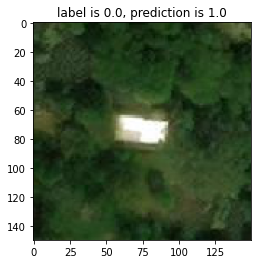

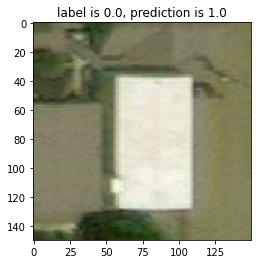

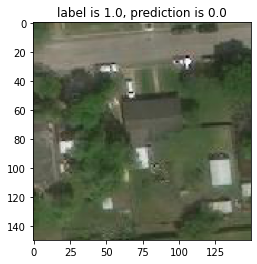

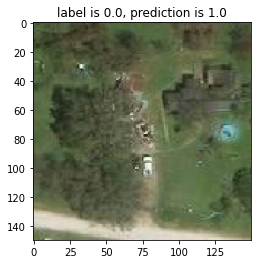

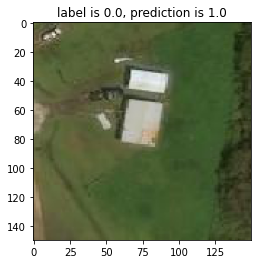

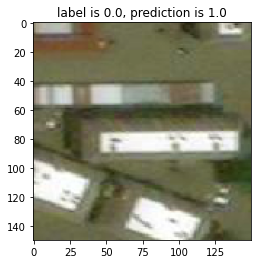

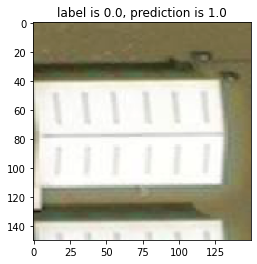

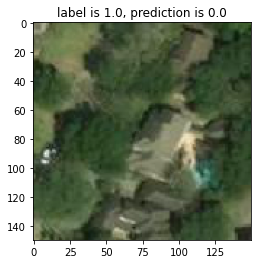

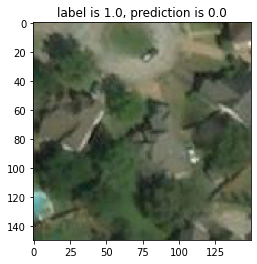

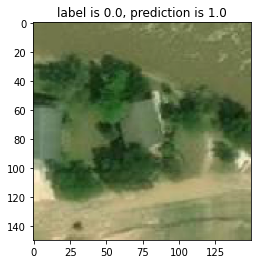

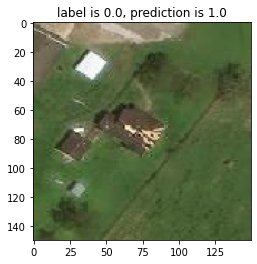

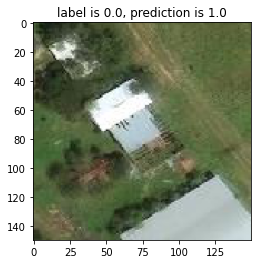

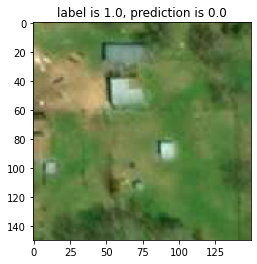

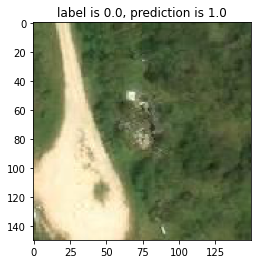

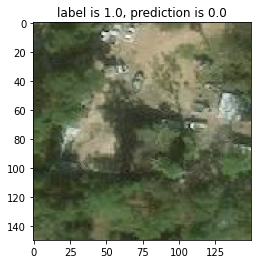

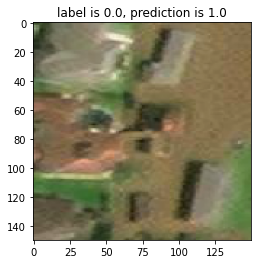

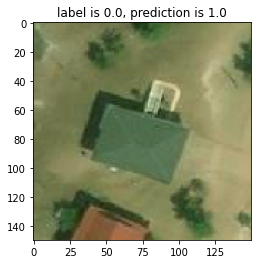

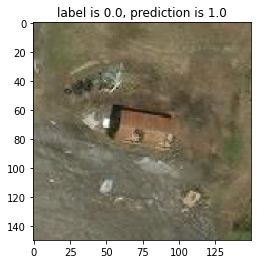

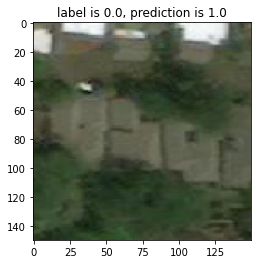

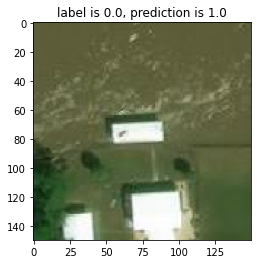

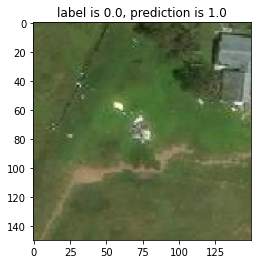

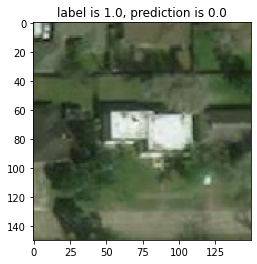

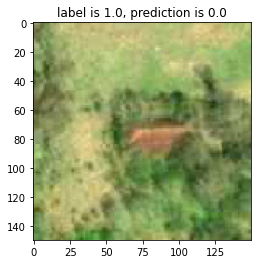

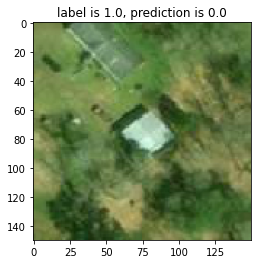

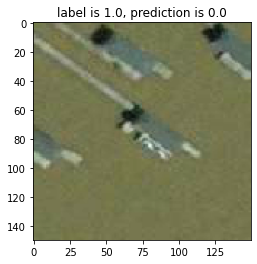

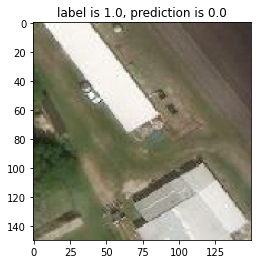

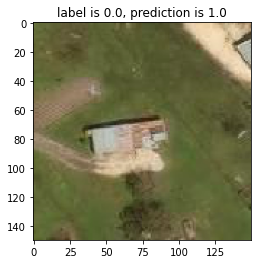

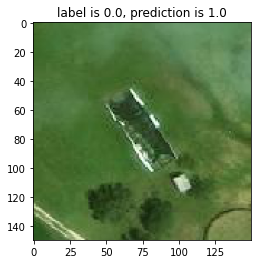

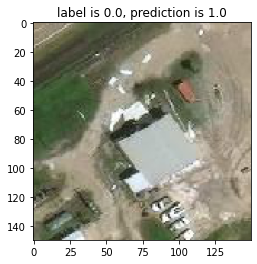

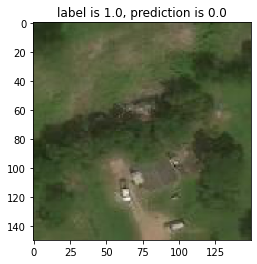

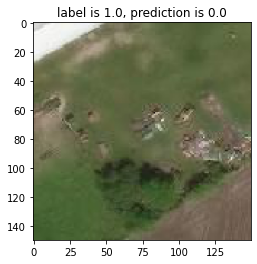

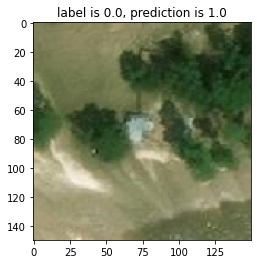

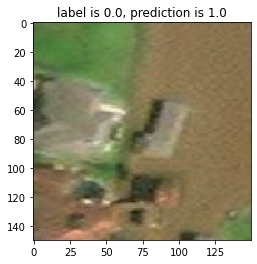

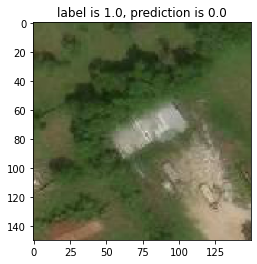

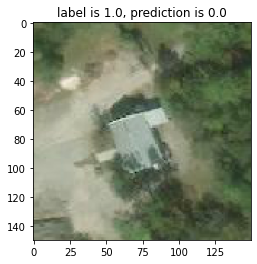

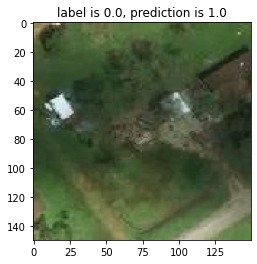

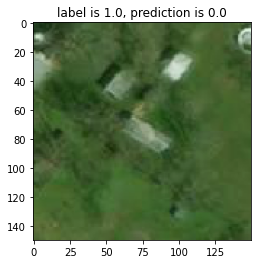

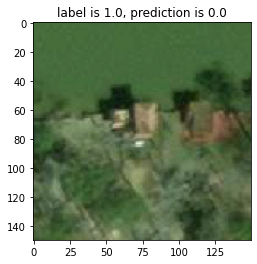

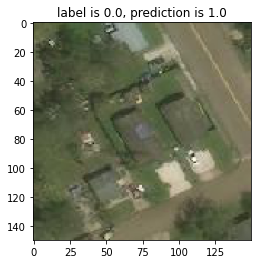

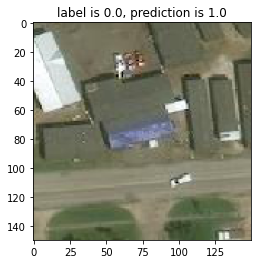

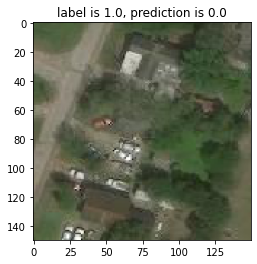

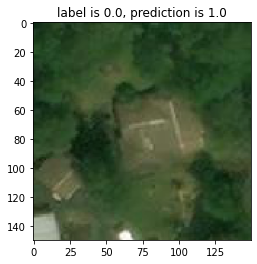

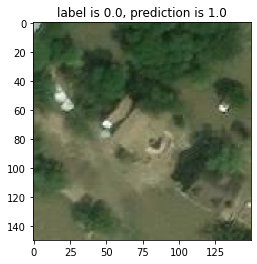

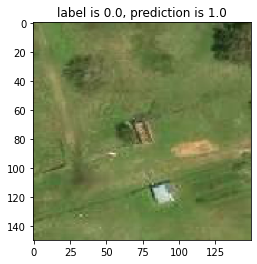

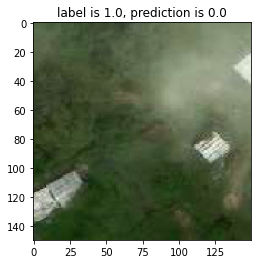

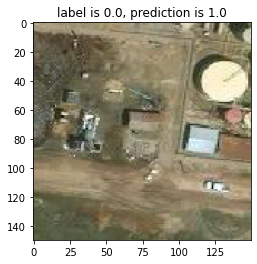

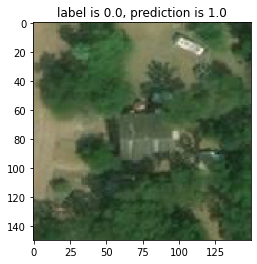

In [ ]:
#Checking which image is misclassified
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#                     '/path/', #change this for balanced/unbalanced test set 
#                     target_size = (150,150),
#                     batch_size = 20,
#                     class_mode = 'binary')
y_pred = []
y_label = []
for i in range(50):
    x,y = test_generator.next()
    y = y.ravel()
    temp_y = model.predict(x)
    temp_y = np.round(temp_y.ravel())
    misclassification = np.absolute(y-temp_y)

    #show the misclassification
    misclass_index = np.where(misclassification > 0.5)
    for j in range(len(misclass_index[0])):
        plt.figure()
        #print(misclass_index[0][j])
        plt.title('label is {}, prediction is {}'.format(y[misclass_index[0][j]],temp_y[misclass_index[0][j]]))
        plt.imshow(image.array_to_img(x[misclass_index[0][j]]))
    misclass_index = None